# Final Report

**Group 33: Yiran Hou, Uday Kapoor, Kunyue Liu, Christopher Mok**

### (1) Introduction

Diabetes is one of the most common diseases in modern society, which includes a group of conditions in which a patient’s blood sugar level is higher than normal standards. Diabetes raises health problems for hundreds of millions of people around the world every year, including long-term damage, organ breakdown, and organ failure, happening in multiple organs in the body (Arora et al., 2022). Machine Learning, a quickly developing technique, has been frequently studied and applied to the healthcare industry. Researchers have worked on building classifiers to improve diabetes diagnosis at the early stage. The ability to diagnose diabetes early will enable specialists to intervene efficiently in the course of the disease. 

In diagnosing diabetes, modeling methodologies, such as KNN, Decision Tree, Neural Network, Logistic Regression, and SVM, are highly incorporated in the studies (Arora et al., 2022). Many researchers trained the classifiers on the existing datasets and improved their models based on the previous studies. 

We use the Pima Indians Diabetes Database, which includes several predictive factors such as glucose levels, blood pressure, BMI, age, and Diabetes Pedigree Function. This dataset has been frequently used in diabetes prediction research in recent decades. So, to start an early exploration of the dataset, we refer to the results of some existing modeling to investigate essential predictors among all the given features. According to a decision-tree model, which diagnosed type II diabetes, key features involved in the decision nodes are **Glucose, Age, BMI, Diabetes Pedigree Function, and Pregnancy** (Al Jarullah, 2011). From the experiment to build a hybrid intelligence system, researchers especially applied the GA method to feature reduction, capturing essential features, including **Glucose, Age, BMI, and Insulin** (Birla Institute of Technology, Computer Science & Engineering, Mesra, Ranchi, India, et al., 2016). Another study that included feature selection in building the classifier also identified similar results. Based on the F-scores, core features are **Glucose, BMI, Age, Pregnancy, Diabetes Pedigree Function, and Blood Pressure**. After K-Means clustering, the scale is shrunk to the first three features (Gandhi & Prajapati, 2014). 

This study aims to investigate the potential of machine learning algorithms in predicting the risk of diabetes in individuals using a comprehensive dataset of clinical attributes. Specifically, we seek to answer two key questions:

1. **What is the optimal model to predict the likelihood of diabetes based on clinical features considering key accuracy metrics?**
2. **Is adding interaction terms helpful in improving the diagnosis result of the model?**

By applying machine learning techniques, such as **logistic regression, forward selection, and Lasso regression**, we will identify the key variables influencing the outcome and compare the predictive accuracy of the models. Additionally, by answering the proposed questions, this study will contribute to the ongoing efforts in diabetes research, focusing on how machine learning can improve the precision and reliability of diabetes risk prediction.


### (2) Methods and Results

#### (a) Exploratory Data Analysis (EDA)

In [1]:
# Main developer: Chris, Kunyue, Uday, Yiran

install.packages('cowplot')
install.packages('GGally')
install.packages("ROCR") 
install.packages("leaps")
install.packages("corrplot")
install.packages("glmnet")
install.packages('gridExtra')

# # loading the libararies
library(tidyverse)
library(cowplot)
library(GGally)
library(caret)      # For model training and evaluation
library(ggplot2)    # For visualization
library(pROC)       # For ROC and AUC calculation
library(corrplot)
library(ROCR)
library(glmnet)
library(gridExtra)
library(readr)
library(car)
library(dplyr)
library(ggplot2)
library(broom)
library(leaps)
library(tibble)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

also installing the dependencies ‘gtools’, ‘caTools’, ‘gplots’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks

In [2]:
diabetes_data<-read_csv("data/diabetes.csv")
head(diabetes_data)

Rows: 768 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, D...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
6,148,72,35,0,33.6,0.627,50,1
1,85,66,29,0,26.6,0.351,31,0
8,183,64,0,0,23.3,0.672,32,1
1,89,66,23,94,28.1,0.167,21,0
0,137,40,35,168,43.1,2.288,33,1
5,116,74,0,0,25.6,0.201,30,0


In [3]:
# Main Developer: Uday

data_cleaned <- diabetes_data %>%
  mutate(across(c(Glucose, BloodPressure, SkinThickness, Insulin, BMI), ~ifelse(. == 0, NA, .))) %>%
  drop_na()

cat("Number of rows after cleaning: ", nrow(data_cleaned), "\n")
summary(data_cleaned)

Number of rows after cleaning:  392 


  Pregnancies        Glucose      BloodPressure    SkinThickness  
 Min.   : 0.000   Min.   : 56.0   Min.   : 24.00   Min.   : 7.00  
 1st Qu.: 1.000   1st Qu.: 99.0   1st Qu.: 62.00   1st Qu.:21.00  
 Median : 2.000   Median :119.0   Median : 70.00   Median :29.00  
 Mean   : 3.301   Mean   :122.6   Mean   : 70.66   Mean   :29.15  
 3rd Qu.: 5.000   3rd Qu.:143.0   3rd Qu.: 78.00   3rd Qu.:37.00  
 Max.   :17.000   Max.   :198.0   Max.   :110.00   Max.   :63.00  
    Insulin            BMI        DiabetesPedigreeFunction      Age       
 Min.   : 14.00   Min.   :18.20   Min.   :0.0850           Min.   :21.00  
 1st Qu.: 76.75   1st Qu.:28.40   1st Qu.:0.2697           1st Qu.:23.00  
 Median :125.50   Median :33.20   Median :0.4495           Median :27.00  
 Mean   :156.06   Mean   :33.09   Mean   :0.5230           Mean   :30.86  
 3rd Qu.:190.00   3rd Qu.:37.10   3rd Qu.:0.6870           3rd Qu.:36.00  
 Max.   :846.00   Max.   :67.10   Max.   :2.4200           Max.   :81.00  
    Ou

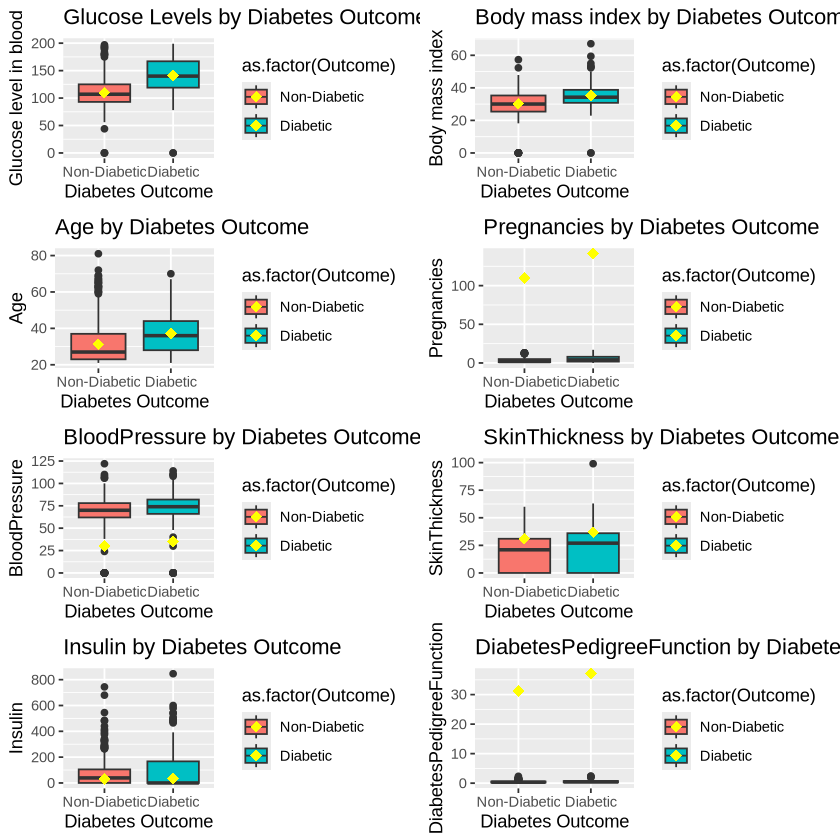

In [5]:
# Main Developer: Yiran 
glucose_outcome <- 
    ggplot(diabetes_data, aes(x = as.factor(Outcome), y = Glucose, fill = as.factor(Outcome))) +
    geom_boxplot() +
    xlab("Diabetes Outcome") +
    ylab("Glucose level in blood") + 
    ggtitle("Glucose Levels by Diabetes Outcome") +
    scale_x_discrete(labels = c("0" = "Non-Diabetic", "1" = "Diabetic")) + 
    scale_fill_discrete(labels = c("Non-Diabetic", "Diabetic")) +  
    stat_summary(aes(x= as.factor(Outcome), y= Glucose, fill = as.factor(Outcome)),
	fun = mean, color = "yellow", geom = "point", shape = 18, size = 3) 

bmi_outcome <- 
    ggplot(diabetes_data, aes(x = as.factor(Outcome), y = BMI, fill = as.factor(Outcome))) +
    geom_boxplot() +
    xlab("Diabetes Outcome") +
    ylab("Body mass index") + 
    ggtitle("Body mass index by Diabetes Outcome") +
    scale_x_discrete(labels = c("0" = "Non-Diabetic", "1" = "Diabetic")) + 
    scale_fill_discrete(labels = c("Non-Diabetic", "Diabetic")) + 
    stat_summary(aes(x= as.factor(Outcome), y= BMI, fill = as.factor(Outcome)),
	fun = mean, color = "yellow", geom = "point", shape = 18, size = 3) 

age_outcome <- 
    ggplot(diabetes_data, aes(x = as.factor(Outcome), y = Age, fill = as.factor(Outcome))) +
    geom_boxplot() +
    xlab("Diabetes Outcome") +
    ylab("Age") + 
    ggtitle("Age by Diabetes Outcome") +
    scale_x_discrete(labels = c("0" = "Non-Diabetic", "1" = "Diabetic")) +
    scale_fill_discrete(labels = c("Non-Diabetic", "Diabetic")) + 
    stat_summary(aes(x= as.factor(Outcome), y= Age, fill = as.factor(Outcome)),
	fun = mean, color = "yellow", geom = "point", shape = 18, size = 3) 

pregnancies_outcome <- 
    ggplot(diabetes_data, aes(x = as.factor(Outcome), y = Pregnancies, fill = as.factor(Outcome))) +
    geom_boxplot() +
    xlab("Diabetes Outcome") +
    ylab("Pregnancies") + 
    ggtitle("Pregnancies by Diabetes Outcome") +
    scale_x_discrete(labels = c("0" = "Non-Diabetic", "1" = "Diabetic")) + 
    scale_fill_discrete(labels = c("Non-Diabetic", "Diabetic")) +  
    stat_summary(aes(x= as.factor(Outcome), y= Glucose, fill = as.factor(Outcome)),
	fun = mean, color = "yellow", geom = "point", shape = 18, size = 3) 

bloodpressure_outcome <- 
    ggplot(diabetes_data, aes(x = as.factor(Outcome), y = BloodPressure, fill = as.factor(Outcome))) +
    geom_boxplot() +
    xlab("Diabetes Outcome") +
    ylab("BloodPressure") + 
    ggtitle("BloodPressure by Diabetes Outcome") +
    scale_x_discrete(labels = c("0" = "Non-Diabetic", "1" = "Diabetic")) + 
    scale_fill_discrete(labels = c("Non-Diabetic", "Diabetic")) + 
    stat_summary(aes(x= as.factor(Outcome), y= BMI, fill = as.factor(Outcome)),
	fun = mean, color = "yellow", geom = "point", shape = 18, size = 3) 

skinthickness_outcome <- 
    ggplot(diabetes_data, aes(x = as.factor(Outcome), y = SkinThickness, fill = as.factor(Outcome))) +
    geom_boxplot() +
    xlab("Diabetes Outcome") +
    ylab("SkinThickness") + 
    ggtitle("SkinThickness by Diabetes Outcome") +
    scale_x_discrete(labels = c("0" = "Non-Diabetic", "1" = "Diabetic")) +
    scale_fill_discrete(labels = c("Non-Diabetic", "Diabetic")) + 
    stat_summary(aes(x= as.factor(Outcome), y= Age, fill = as.factor(Outcome)),
	fun = mean, color = "yellow", geom = "point", shape = 18, size = 3) 

insulin_outcome <- 
    ggplot(diabetes_data, aes(x = as.factor(Outcome), y = Insulin, fill = as.factor(Outcome))) +
    geom_boxplot() +
    xlab("Diabetes Outcome") +
    ylab("Insulin") + 
    ggtitle("Insulin by Diabetes Outcome") +
    scale_x_discrete(labels = c("0" = "Non-Diabetic", "1" = "Diabetic")) + 
    scale_fill_discrete(labels = c("Non-Diabetic", "Diabetic")) + 
    stat_summary(aes(x= as.factor(Outcome), y= BMI, fill = as.factor(Outcome)),
	fun = mean, color = "yellow", geom = "point", shape = 18, size = 3) 

diabetesedigreefunction_outcome <- 
    ggplot(diabetes_data, aes(x = as.factor(Outcome), y = DiabetesPedigreeFunction, fill = as.factor(Outcome))) +
    geom_boxplot() +
    xlab("Diabetes Outcome") +
    ylab("DiabetesPedigreeFunction") + 
    ggtitle("DiabetesPedigreeFunction by Diabetes Outcome") +
    scale_x_discrete(labels = c("0" = "Non-Diabetic", "1" = "Diabetic")) +
    scale_fill_discrete(labels = c("Non-Diabetic", "Diabetic")) + 
    stat_summary(aes(x= as.factor(Outcome), y= Age, fill = as.factor(Outcome)),
	fun = mean, color = "yellow", geom = "point", shape = 18, size = 3) 

grid.arrange(glucose_outcome,bmi_outcome,
             age_outcome,pregnancies_outcome,
             bloodpressure_outcome,skinthickness_outcome, 
             insulin_outcome, diabetesedigreefunction_outcome, ncol=2)

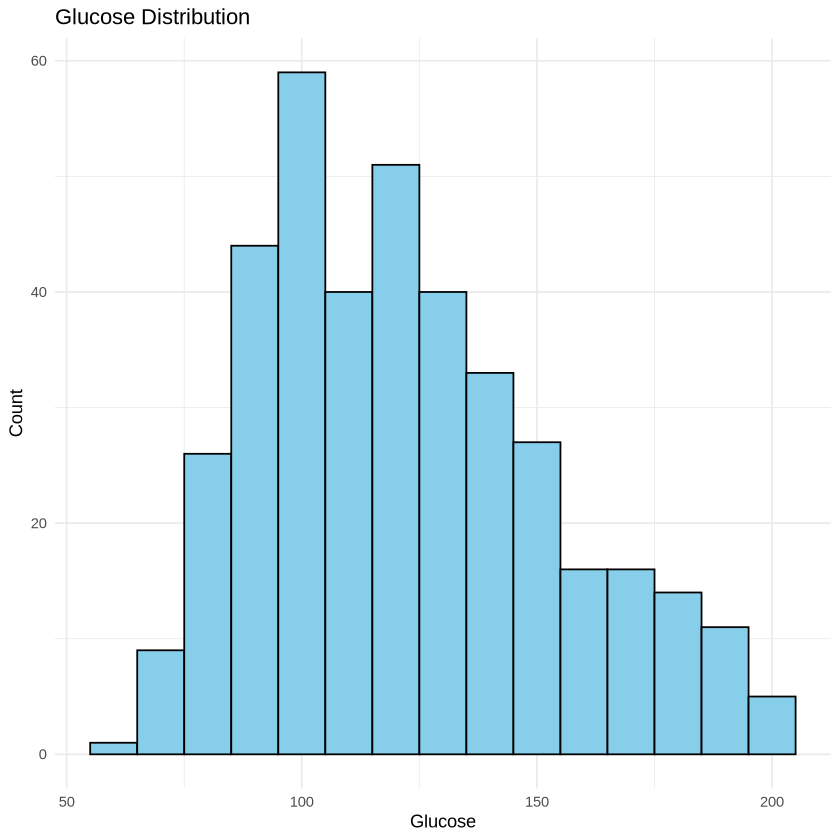

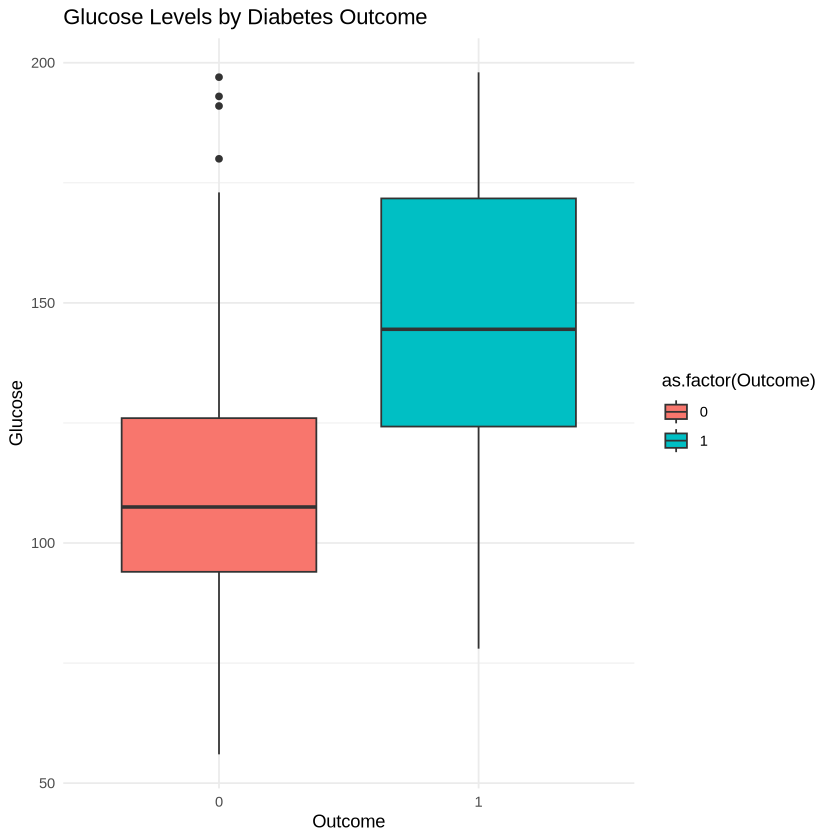

In [6]:
# Distribution of Glucose
ggplot(data_cleaned, aes(x = Glucose)) +
  geom_histogram(binwidth = 10, fill = "skyblue", color = "black") +
  labs(title = "Glucose Distribution", x = "Glucose", y = "Count") +
  theme_minimal()

# Boxplot of Glucose by Outcome
ggplot(data_cleaned, aes(x = as.factor(Outcome), y = Glucose, fill = as.factor(Outcome))) +
  geom_boxplot() +
  labs(title = "Glucose Levels by Diabetes Outcome", x = "Outcome", y = "Glucose") +
  theme_minimal()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Pregnancies,1.000000000,0.1982910,0.2133548,0.0932094,0.07898363,-0.02534728,0.007562116,0.67960847
Glucose,0.198291043,1.0000000,0.2100266,0.1988558,0.58122301,0.20951592,0.140180180,0.34364150
BloodPressure,0.213354775,0.2100266,1.0000000,0.2325712,0.09851150,0.30440337,-0.015971104,0.30003895
SkinThickness,0.093209397,0.1988558,0.2325712,1.0000000,0.18219906,0.66435487,0.160498526,0.16776114
Insulin,0.078983625,0.5812230,0.0985115,0.1821991,1.00000000,0.22639652,0.135905781,0.21708199
BMI,-0.025347276,0.2095159,0.3044034,0.6643549,0.22639652,1.00000000,0.158771043,0.06981380
DiabetesPedigreeFunction,0.007562116,0.1401802,-0.0159711,0.1604985,0.13590578,0.15877104,1.000000000,0.08502911
Age,0.679608470,0.3436415,0.3000389,0.1677611,0.21708199,0.06981380,0.085029106,1.00000000


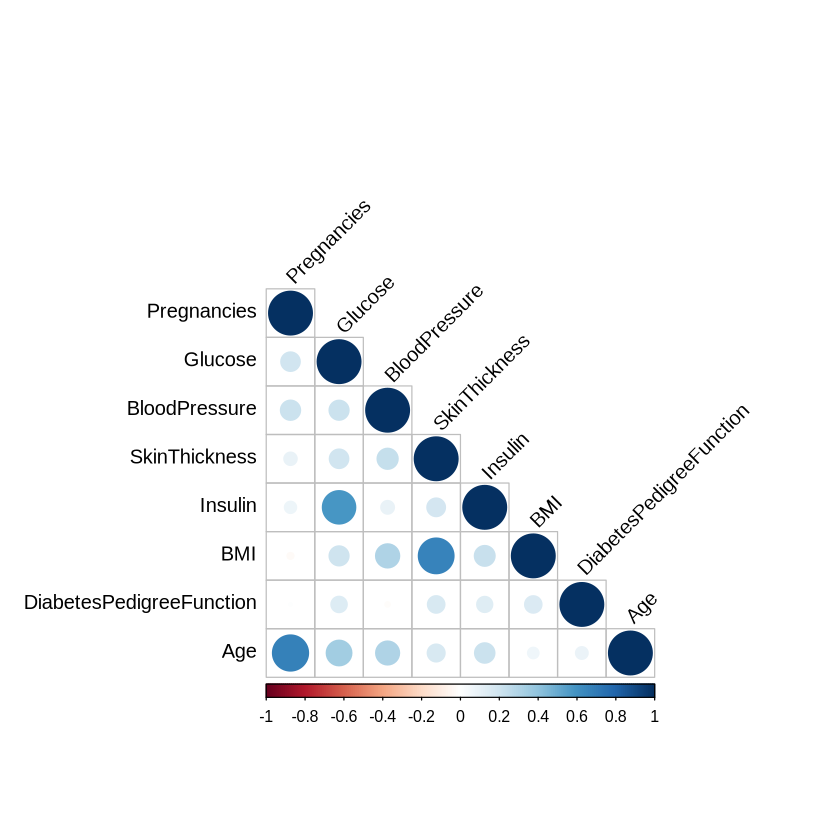

In [7]:
# Main Developer: Uday

numeric_vars <- data_cleaned %>% select(-Outcome)
cor_matrix <- cor(numeric_vars)
cor_matrix
corrplot(cor_matrix, method = "circle", type = "lower", tl.col = "black", tl.srt = 45)

In [8]:
# Main Developer: Uday

scaled_data <- data_cleaned %>%
  mutate(across(-Outcome, scale))
head(scaled_data)

Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>",<dbl>
-0.71651083,-1.0896533,-0.37317791,-0.5843629,-0.5221747,-0.7095143,-1.0305593,-0.9670632,0
-1.02789913,0.4657189,-2.45382847,0.5567094,0.1005024,1.4249091,5.1085822,0.2093178,1
-0.09373423,-1.4460927,-1.65357826,0.2714413,-0.5726620,-0.2968591,-0.7961084,-0.4769045,1
-0.40512253,2.4099341,-0.05307782,1.5076030,3.2559608,-0.3680065,-1.0566094,2.1699528,1
-0.71651083,2.1507054,-0.85332804,-0.5843629,5.8055711,-0.4249245,-0.3619399,2.7581434,1
0.52904237,1.4054229,0.10697222,-0.9647204,0.1594043,-1.0367925,0.1851123,1.9738893,1


#### (b) Methods: Plan 

Method in English: Need to be added by Yiran

Result from Out Individual Assignment

In [51]:
# Main developer: Yiran Hou, Kunyue Liu

#training data/testing data
set.seed(123)
diabetes_train <- 
    scaled_data %>% 
    slice_sample(prop = 0.70)

diabetes_test <- 
    scaled_data %>% 
    anti_join(diabetes_train, by = "Outcome")

subset_selection <- regsubsets(Outcome ~ ., 
                                 data = diabetes_train, 
                                 nvmax = 8, 
                                 method = "forward")
subset_summary <- summary(subset_selection)

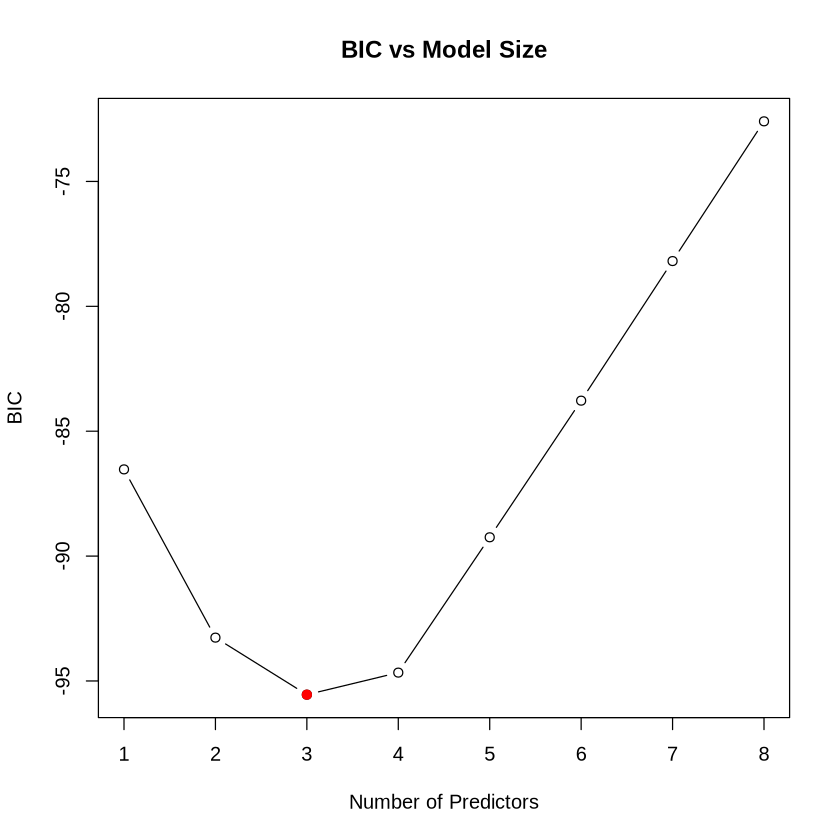

In [52]:
# Plot BIC vs Model Size
plot(subset_summary$bic, type = "b", 
     xlab = "Number of Predictors", 
     ylab = "BIC", 
     main = "BIC vs Model Size")
points(which.min(subset_summary$bic), min(subset_summary$bic), col = "red", pch = 19)


In [54]:
# Retrieve the best variables
best_model_size <- which.min(subset_summary$bic)
best_model_vars <- names(coef(subset_selection, best_model_size))[-1]
best_model_vars

[1] "Glucose" "BMI"     "Age"

In [55]:
# additive_model <- 
interactive_selection <- regsubsets(Outcome ~ Glucose * BMI + Glucose * Age + BMI * Age, 
                                    data = diabetes_train, 
                                    nvmax = 6,
                                    method = "forward")

additive_summary <- summary(additive_selection)
interactive_summary <- summary(interactive_selection)

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'object' in selecting a method for function 'summary': object 'additive_selection' not found


In [29]:
comparison_tibble <- tibble(
  Model = c(rep("Additive", 3), rep("Interactive", 6)),
  n_input_variables = c(1:3, 1:6),
  Adjusted_R2 = c(additive_summary$adjr2, interactive_summary$adjr2),
  BIC = c(additive_summary$bic, interactive_summary$bic),
  Cp = c(additive_summary$cp, interactive_summary$cp)
)


logistic_model <- glm(Outcome ~ Glucose + BMI + Age, data = diabetes_train, family = binomial)
tidy_logistic_model <- tidy(logistic_model, conf.int = TRUE)

tidy_logistic_model <- 
    tidy_logistic_model %>%
        mutate(oddsratio = exp(estimate),
               lowerci = exp(conf.low),
               upperci = exp(conf.high)) %>%
        select(term, oddsratio, lowerci, upperci, p.value)

tidy_logistic_model

term,oddsratio,lowerci,upperci,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.00022876,4.592442e-05,0.001007777,1.608471e-26
Glucose,1.03285931,1.024942e+00,1.041386368,1.486893e-15
BMI,1.08467504,1.051583e+00,1.121031855,6.070357e-07
Age,1.03076913,1.012609e+00,1.049490579,8.713864e-04


In [30]:
roc_curve <- 
    roc(
        response = diabetes_test$Outcome, 
        predictor = predict(logistic_model, newdata = diabetes_test, type = "response"))

plot(roc_curve,
  print.auc = TRUE, col = "blue", lwd = 3, lty = 2,
  main = "ROC Curves for Diabetes Dataset"
)

ERROR: Error in family(object)$linkinv(pred): Argument eta must be a nonempty numeric vector


The best model in Yiran's individual assignment is an addictive model for Glucose, BMI and Age:
> logit(`Outcome`) = -8.386 + 0.0329 * `Glucose` + 0.0847 * `BMI` + 0.0308 * `Age

### Logistic Regression and Forward Selection

In [11]:
# Main developer: Kunyue

In [12]:
# Split Dataset
train_index <- sample(1:nrow(scaled_data), 0.7 * nrow(scaled_data))
train_data <- scaled_data[train_index, ]
test_data <- scaled_data[-train_index, ]


In [13]:
# Forward Selection
subset_selection <- regsubsets(Outcome ~ ., 
                                data = train_data, 
                                method = "forward", 
                                nvmax = ncol(df) - 1)

subset_summary <- summary(subset_selection)

In [14]:
subset_summary$bic

[1] -85.35621 -90.44985 -94.17764 -97.89055 -94.01051 -89.56274 -84.87446
[8] -80.08774

In [15]:
# Retrieve the best model
best_model_size <- which.min(subset_summary$bic)
best_model_vars <- names(coef(subset_selection, best_model_size))[-1]

In [16]:
# Select the features in the dataset
train_subset <- 
    train_data %>% 
    select(best_model_vars, Outcome)

test_subset <- 
    test_data %>% 
    select(best_model_vars, Outcome)

Warning message:
“Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(best_model_vars)

  # Now:
  data %>% select(all_of(best_model_vars))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.”


In [17]:
# Finalize the model
final_model <- glm(Outcome ~ ., data = train_subset, family = 'binomial')
summary(final_model)


Call:
glm(formula = Outcome ~ ., family = "binomial", data = train_subset)

Coefficients:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)               -1.0542     0.1756  -6.002 1.95e-09 ***
Glucose                    1.2018     0.1832   6.560 5.36e-11 ***
BMI                        0.5526     0.1824   3.029  0.00245 ** 
DiabetesPedigreeFunction   0.4930     0.1857   2.655  0.00793 ** 
Age                        0.4975     0.1732   2.872  0.00408 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 348.35  on 273  degrees of freedom
Residual deviance: 233.46  on 269  degrees of freedom
AIC: 243.46

Number of Fisher Scoring iterations: 5


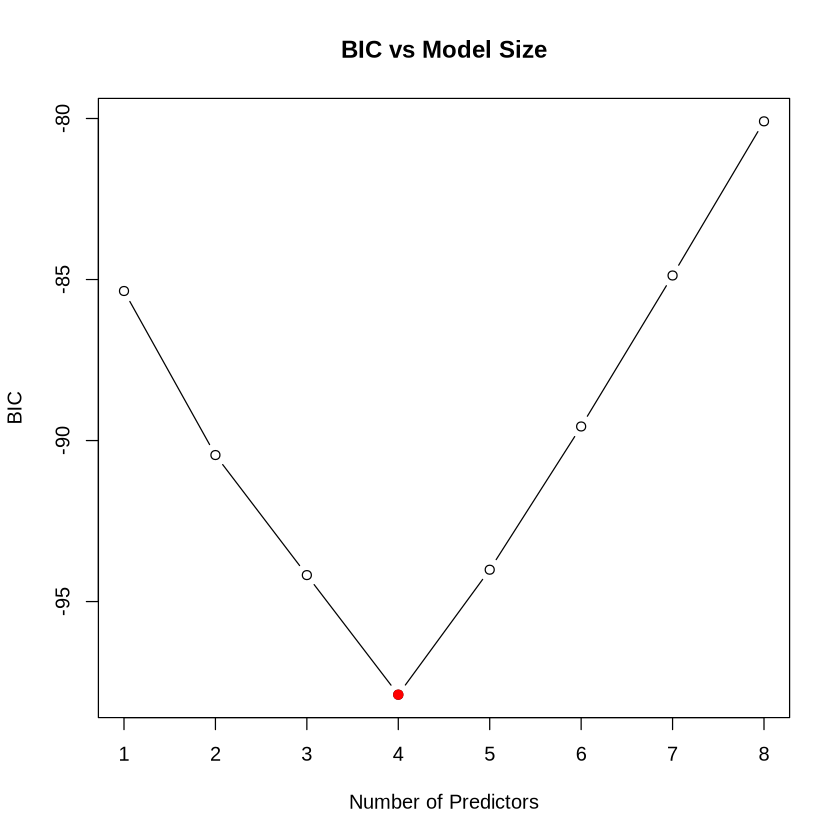

In [18]:
# Plot BIC vs Model Size
plot(subset_summary$bic, type = "b", 
     xlab = "Number of Predictors", 
     ylab = "BIC", 
     main = "BIC vs Model Size")
points(which.min(subset_summary$bic), min(subset_summary$bic), col = "red", pch = 19)


According to the BIC plot, the best model has four features.
The logistic regression model with forward selection identifies key features that contribute to the prediction of diabetes:
- Pregnancies               0.162468
- Glucose                   0.032394
- BMI                       0.076593
- DiabetesPedigreeFunction  1.134569

Setting levels: control = 0, case = 1

Setting direction: controls < cases



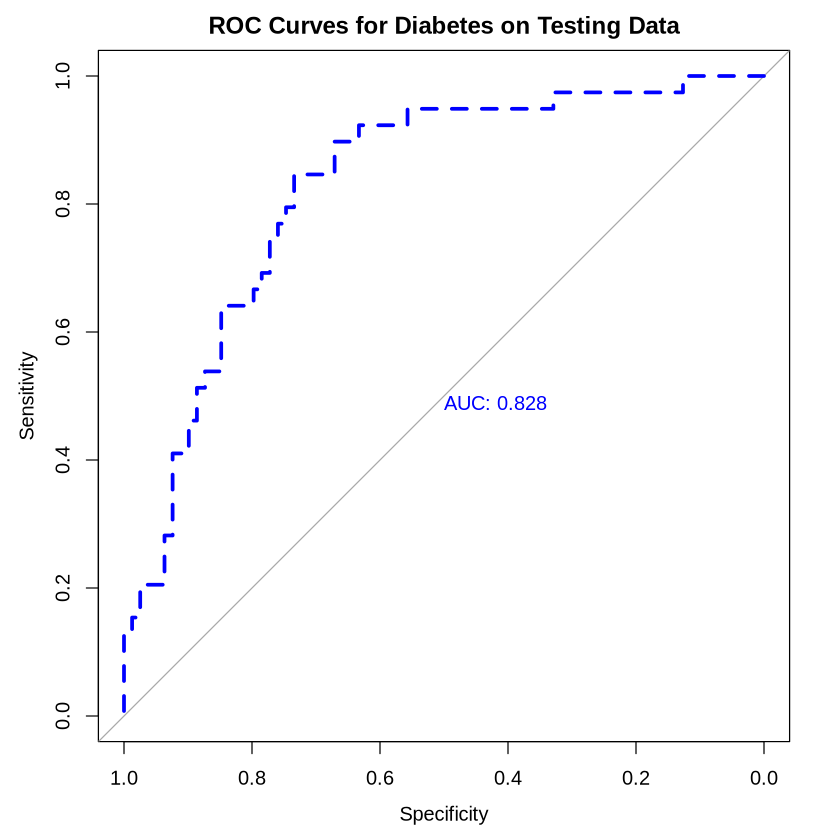

In [19]:
# ROC on testing data with the final model
ROC_full_log_test <- roc(
  response = test_subset$Outcome,
  predictor = predict(final_model,newdata=test_subset,type="response")
)
plot(ROC_full_log_test,
  print.auc = TRUE, col = "blue", lwd = 3, lty = 2,
  main = "ROC Curves for Diabetes on Testing Data"
)

In [20]:
# Confusion matrix of the final model on testing data
diabetes_pred_class_test <- round(predict(final_model, test_subset, type='response'),0)
diabetes_test_confusion_matrix <- 
    confusionMatrix(
    data = as.factor(diabetes_pred_class_test),
    reference = as.factor(test_subset$Outcome),
    positive = "1"
)
diabetes_test_confusion_matrix

Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 71 22
         1  8 17
                                          
               Accuracy : 0.7458          
                 95% CI : (0.6574, 0.8214)
    No Information Rate : 0.6695          
    P-Value [Acc > NIR] : 0.04583         
                                          
                  Kappa : 0.3681          
                                          
 Mcnemar's Test P-Value : 0.01762         
                                          
            Sensitivity : 0.4359          
            Specificity : 0.8987          
         Pos Pred Value : 0.6800          
         Neg Pred Value : 0.7634          
             Prevalence : 0.3305          
         Detection Rate : 0.1441          
   Detection Prevalence : 0.2119          
      Balanced Accuracy : 0.6673          
                                          
       'Positive' Class : 1               
                                    

##### Logistic Regression

In [21]:
# Main Developer: Uday

# Splitting data
train_index <- createDataPartition(data_cleaned$Outcome, p = 0.8, list = FALSE)
train_data <- data_cleaned[train_index, ]
test_data <- data_cleaned[-train_index, ]

# Logistic regression model
log_model <- glm(Outcome ~ ., data = train_data, family = "binomial")
summary(log_model)

# Predictions and evaluation
log_pred_prob <- predict(log_model, test_data, type = "response")
log_pred <- ifelse(log_pred_prob > 0.5, 1, 0)
conf_matrix <- table(Predicted = log_pred, Actual = test_data$Outcome)
cat("Confusion Matrix (Logistic Regression):\n")
print(conf_matrix)

# Accuracy
accuracy <- sum(diag(conf_matrix)) / sum(conf_matrix)
cat("Accuracy (Logistic Regression):", accuracy, "\n")

# AUC Calculation for Logistic Regression
log_roc_pred <- prediction(log_pred_prob, test_data$Outcome)
log_roc_perf <- performance(log_roc_pred, measure = "tpr", x.measure = "fpr")
auc_log <- performance(log_roc_pred, measure = "auc")@y.values[[1]]
cat("AUC (Logistic Regression):", auc_log, "\n")


Call:
glm(formula = Outcome ~ ., family = "binomial", data = train_data)

Coefficients:
                           Estimate Std. Error z value Pr(>|z|)    
(Intercept)              -1.021e+01  1.349e+00  -7.570 3.75e-14 ***
Pregnancies               1.034e-01  6.494e-02   1.593  0.11118    
Glucose                   3.837e-02  6.314e-03   6.077 1.23e-09 ***
BloodPressure             6.030e-03  1.372e-02   0.439  0.66037    
SkinThickness             1.844e-02  1.851e-02   0.996  0.31912    
Insulin                  -3.087e-04  1.380e-03  -0.224  0.82299    
BMI                       5.497e-02  3.042e-02   1.807  0.07075 .  
DiabetesPedigreeFunction  1.295e+00  4.871e-01   2.658  0.00786 ** 
Age                       2.161e-02  1.948e-02   1.109  0.26738    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 398.80  on 313  degrees of freedom
Residual deviance: 277.37  on 305  degrees of freed

Confusion Matrix (Logistic Regression):
         Actual
Predicted  0  1
        0 50 13
        1  2 13
Accuracy (Logistic Regression): 0.8076923 
AUC (Logistic Regression): 0.8639053 


##### Lasso Regression

Best Lambda for Lasso: 0.008468285 
9 x 1 sparse Matrix of class "dgCMatrix"
                                   s1
(Intercept)              -9.138332887
Pregnancies               0.082103005
Glucose                   0.035097480
BloodPressure             0.004156071
SkinThickness             0.015853866
Insulin                   .          
BMI                       0.047140622
DiabetesPedigreeFunction  1.056346558
Age                       0.021444881
Confusion Matrix (Lasso Regression):
         Actual
Predicted  0  1
        0 50 13
        1  2 13
Accuracy (Lasso Regression): 0.8076923 
AUC (Lasso Regression): 0.8676036 


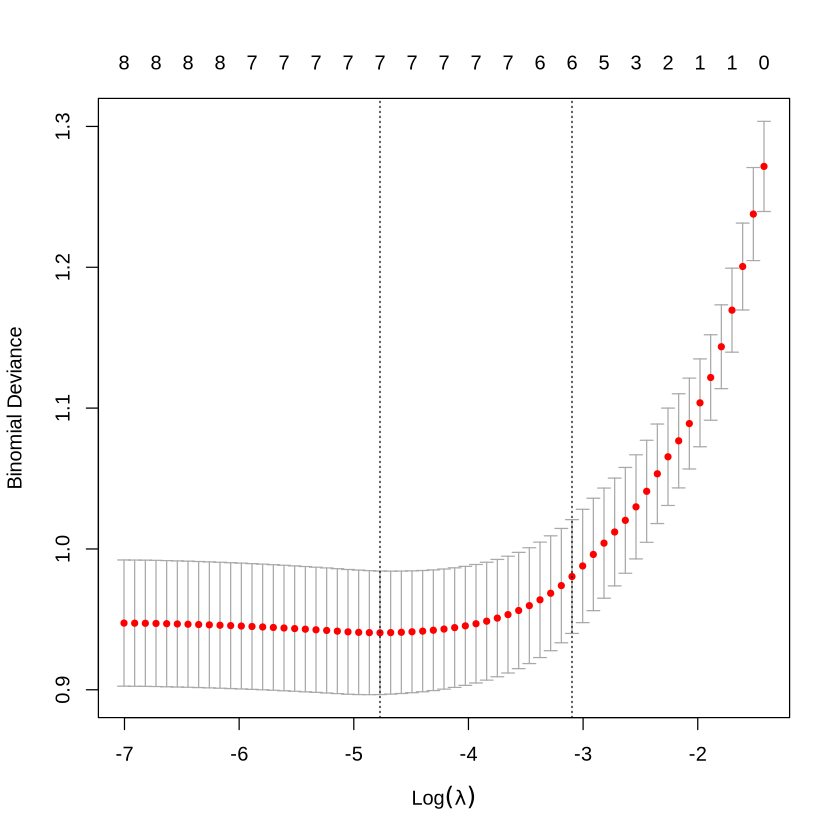

In [22]:
# Main Developer: Uday

# Lasso regression model (with cross-validation)
x_train <- as.matrix(train_data %>% select(-Outcome))
y_train <- train_data$Outcome

lasso_model <- cv.glmnet(x_train, y_train, alpha = 1, family = "binomial")
plot(lasso_model)

# Coefficients at the best lambda
lasso_best_lambda <- lasso_model$lambda.min
cat("Best Lambda for Lasso:", lasso_best_lambda, "\n")
lasso_coefs <- coef(lasso_model, s = "lambda.min")
print(lasso_coefs)

# Predictions and evaluation
x_test <- as.matrix(test_data %>% select(-Outcome))
lasso_pred_prob <- predict(lasso_model, x_test, s = "lambda.min", type = "response")
lasso_pred <- ifelse(lasso_pred_prob > 0.5, 1, 0)
lasso_conf_matrix <- table(Predicted = lasso_pred, Actual = test_data$Outcome)
cat("Confusion Matrix (Lasso Regression):\n")
print(lasso_conf_matrix)

# Accuracy
lasso_accuracy <- sum(diag(lasso_conf_matrix)) / sum(lasso_conf_matrix)
cat("Accuracy (Lasso Regression):", lasso_accuracy, "\n")

# AUC Calculation for Lasso Regression
lasso_roc_pred <- prediction(lasso_pred_prob, test_data$Outcome)
lasso_roc_perf <- performance(lasso_roc_pred, measure = "tpr", x.measure = "fpr")
auc_lasso <- performance(lasso_roc_pred, measure = "auc")@y.values[[1]]
cat("AUC (Lasso Regression):", auc_lasso, "\n")

### (3) Discussion

#### Summary of Findings

In this analysis, we set out to determine the diagnostic factors most strongly associated with diabetes in a dataset of Pima Indian women. We utilized **Logistic Regression** and **Lasso Regression** models to identify key predictors and assess their effectiveness in predicting the outcome variable, whether the individual has diabetes (binary classification: 0 = no, 1 = yes).

1. **Logistic Regression Results**:
   - **Significant predictors** of diabetes in the logistic regression model include:
     - **Glucose** (p-value < 0.001): Glucose levels are strongly correlated with the likelihood of diabetes. This aligns with known research that high glucose levels are a primary factor in the diagnosis of diabetes.
     - **Diabetes Pedigree Function** (p-value = 0.0232): This measure of family history is another significant predictor, suggesting that genetic predisposition plays a role in diabetes risk.
     - **BMI** (p-value = 0.0668): Though not highly significant (p-value slightly greater than 0.05), BMI also shows a trend suggesting that higher body mass index increases the likelihood of diabetes.
   - **Other variables** like **Pregnancies**, **Blood Pressure**, **Skin Thickness**, and **Insulin** did not show strong significance. For example, insulin had a p-value of 0.4744, indicating that its effect on predicting diabetes was negligible in this dataset, which could be a result of multicollinearity or a data issue (e.g., many zero values).
   - The **AUC** for the logistic regression model was **0.8535**, indicating a good predictive performance. The model's accuracy was 78.21%, meaning it correctly classified 78.21% of the observations, though there is room for improvement, particularly in reducing false positives (12 predicted non-diabetic as diabetic).

2. **Lasso Regression Results**:
   - The **Lasso Regression** model was applied to help identify the most important predictors while also regularizing the coefficients to prevent overfitting.
   - The **Best Lambda** found was **0.0139**, indicating the optimal level of regularization that minimizes model complexity while maintaining predictive performance.
   - Key predictors in the Lasso model are similar to those in the logistic regression model, including **Glucose**, **BMI**, and **Diabetes Pedigree Function**. However, **Blood Pressure** and **Insulin** were excluded from the model due to their coefficients being shrunk to zero, suggesting they are less relevant in predicting diabetes in this dataset.
   - The **AUC** for the Lasso model was **0.8513**, slightly lower than the logistic regression model (0.8535), with an accuracy of **76.92%**. Although the Lasso model has a slightly lower accuracy, it is more robust in handling multicollinearity and can generalize better to unseen data.

#### Implications and Impact

- **Glucose** levels remain the strongest predictor of diabetes in both models, which is consistent with existing medical research that links high blood glucose levels with the onset of diabetes. Therefore, focusing on glucose monitoring and management could be crucial for early detection and prevention.
- **Diabetes Pedigree Function** also plays an important role, indicating that family history is a significant risk factor. This suggests that individuals with a family history of diabetes should be more vigilant in screening and managing potential risk factors.
- The **slightly weaker performance of the Lasso model** highlights that while regularization is helpful for reducing model complexity and preventing overfitting, it may exclude some potentially useful predictors. This suggests a trade-off between interpretability and performance, as models with fewer predictors are easier to explain but might miss out on subtle relationships between variables.
  
#### Model Improvements

While both models showed good predictive performance, there are areas where they can be improved:

1. **Data Preprocessing**:
   - Although we addressed missing values and outliers, additional techniques like **feature scaling** or **normalization** could potentially improve model performance, especially for models like logistic regression that may be sensitive to the scale of the data.
   - Further exploration of **interaction terms** (e.g., interactions between BMI and glucose levels) could reveal more complex relationships in predicting diabetes.
   
2. **Model Tuning**:
   - For the **Lasso model**, fine-tuning the regularization parameter (lambda) using **cross-validation** could provide a more accurate regularization strength.
   - The **Logistic Regression** model can also benefit from more rigorous **hyperparameter tuning** (e.g., adjusting for different interaction terms or polynomial terms).
   
3. **Alternative Models**:
   - Other machine learning models like **Random Forests** or **Support Vector Machines** (SVM) could be explored to improve prediction accuracy. These models may perform better with non-linear relationships and interactions between variables.
   - Additionally, **ensemble methods** (e.g., boosting or bagging) could combine the strengths of multiple models to improve predictive power.

#### Future Research Directions

This study could lead to several interesting follow-up questions and avenues for further research:

1. **Impact of More Variables**:
   - Investigating the inclusion of other health-related features, such as diet, physical activity, or genetic markers, could enhance the model's predictive accuracy.
   
2. **Data Imbalance**:
   - Given that the dataset has a relatively balanced number of diabetic and non-diabetic individuals, future studies could focus on handling imbalanced datasets, especially if we expand to other populations where one class (diabetic or non-diabetic) might be overrepresented.
   
3. **Longitudinal Studies**:
   - Long-term data or longitudinal studies could track the development of diabetes over time. This could help understand how risk factors change and interact over the years and refine early warning systems for diabetes.

4. **Broader Applications**:
   - This model could be adapted for use in clinical settings, assisting healthcare providers in identifying patients at risk of developing diabetes, thus allowing for early intervention strategies and personalized healthcare plans.

In conclusion, both the **Logistic Regression** and **Lasso Regression** models demonstrate that key variables such as **Glucose**, **BMI**, and **Diabetes Pedigree Function** are critical predictors of diabetes in this dataset. While logistic regression shows slightly better performance, the Lasso model offers a more robust framework for handling potential overfitting. Improvements can be made by exploring alternative models, refining the preprocessing steps, and investigating more complex relationships within the data.

### (4) Reference

Arora, N., Singh, A., Al-Dabagh, M. Z. N., & Maitra, S. K. (2022). A Novel Architecture for Diabetes Patients’ Prediction Using K-Means Clustering and SVM. *Mathematical Problems in Engineering, 2022*(1), 4815521. https://doi.org/10.1155/2022/4815521


Al Jarullah, A. A. (2011). Decision tree discovery for the diagnosis of type II diabetes. *2011 International Conference on Innovations in Information Technology*, 303–307. https://doi.org/10.1109/INNOVATIONS.2011.5893838

Birla Institute of Technology, Computer Science & Engineering, Mesra, Ranchi, India, Choubey, D. K., & Paul, S. (2016). GA_MLP NN: A Hybrid Intelligent System for Diabetes Disease Diagnosis. *International Journal of Intelligent Systems and &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Applications, 8*(1), 49–59. https://doi.org/10.5815/ijisa.2016.01.06

Gandhi, K. K., & Prajapati, N. B. (2014). Diabetes prediction using feature selection and classification. *International journal of advance Engineering and Research Development, 1*(05). https://doi.org/10.21090/IJAERD.0105110